In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

In [ ]:
plt.style.use('ggplot')

In [ ]:
import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
df = pd.read_csv('/Reviews.csv')

In [ ]:
df = df.head(500)

In [ ]:
example = df['Text'][50]

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
from transformers import AutoTokenizer

In [ ]:
from scipy.special import softmax

In [ ]:
#^to be applied to outputs to smooth out between 0-1

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [ ]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
#Run sentiment score on Roberta Model
#First, encode text into embeddings model will understand

In [ ]:
encoded_text = tokenizer(example, return_tensors='pt')

In [ ]:
#Run model on encoded text

In [ ]:
output = model(**encoded_text)

In [ ]:
#Change output from tensor to numpie to store it locally

In [ ]:
scores = output[0][0].detach().numpy()

In [ ]:
#apply softmax to scores

In [ ]:
scores = softmax(scores)

In [ ]:
print(scores)

[0.97635514 0.02068746 0.00295737]


In [ ]:
scores_dictionary = {
    'Roberta_neg' : scores[0],
    'Roberta_neu' : scores[1],
    'Robert_pos' : scores[2]
}

In [ ]:
print(scores_dictionary)

{'Roberta_neg': 0.97635514, 'Roberta_neu': 0.020687465, 'Robert_pos': 0.0029573692}


In [ ]:
#Roberta model thinks example comment is much more negative than VADER model, which is correct from human perception

In [ ]:
#Run Roberta model on entire data set
#make a function out of VADER code

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dictionary = {
        'Roberta_neg' : scores[0],
        'Roberta_neu' : scores[1],
        'Roberta_pos' : scores[2]
    }
    return scores_dictionary

In [ ]:
#Iterate over dataset (using iterate code in VADER)

In [ ]:
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    ID = row['Id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
roberta_result = polarity_scores_roberta(text)

In [ ]:
roberta_result

{'Roberta_neg': 0.0024397594,
 'Roberta_neu': 0.011327226,
 'Roberta_pos': 0.986233}

In [ ]:
#rename VADER results to change neg, neu, pos to be defined as from VADER

In [ ]:
results = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  try:
    text = row['Text']
    ID = row['Id']
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both_results = {**vader_result_rename, **roberta_result}
    results[ID] = both_results
  except RuntimeError:
    print(f'Broke for ID {ID}')


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for ID 83
Broke for ID 187


In [ ]:
#^If model breaks, add a try except RuntimeError clause and add message

In [ ]:
results_df = pd.DataFrame(results).T

In [ ]:
results_df = results_df.reset_index().rename(columns = {'index': 'Id'})

In [ ]:
results_df = results_df.merge(df, how = 'left')

In [ ]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,Roberta_neg,Roberta_neu,Roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#Combine and compare scores between models

In [ ]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'Roberta_neg', 'Roberta_neu', 'Roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

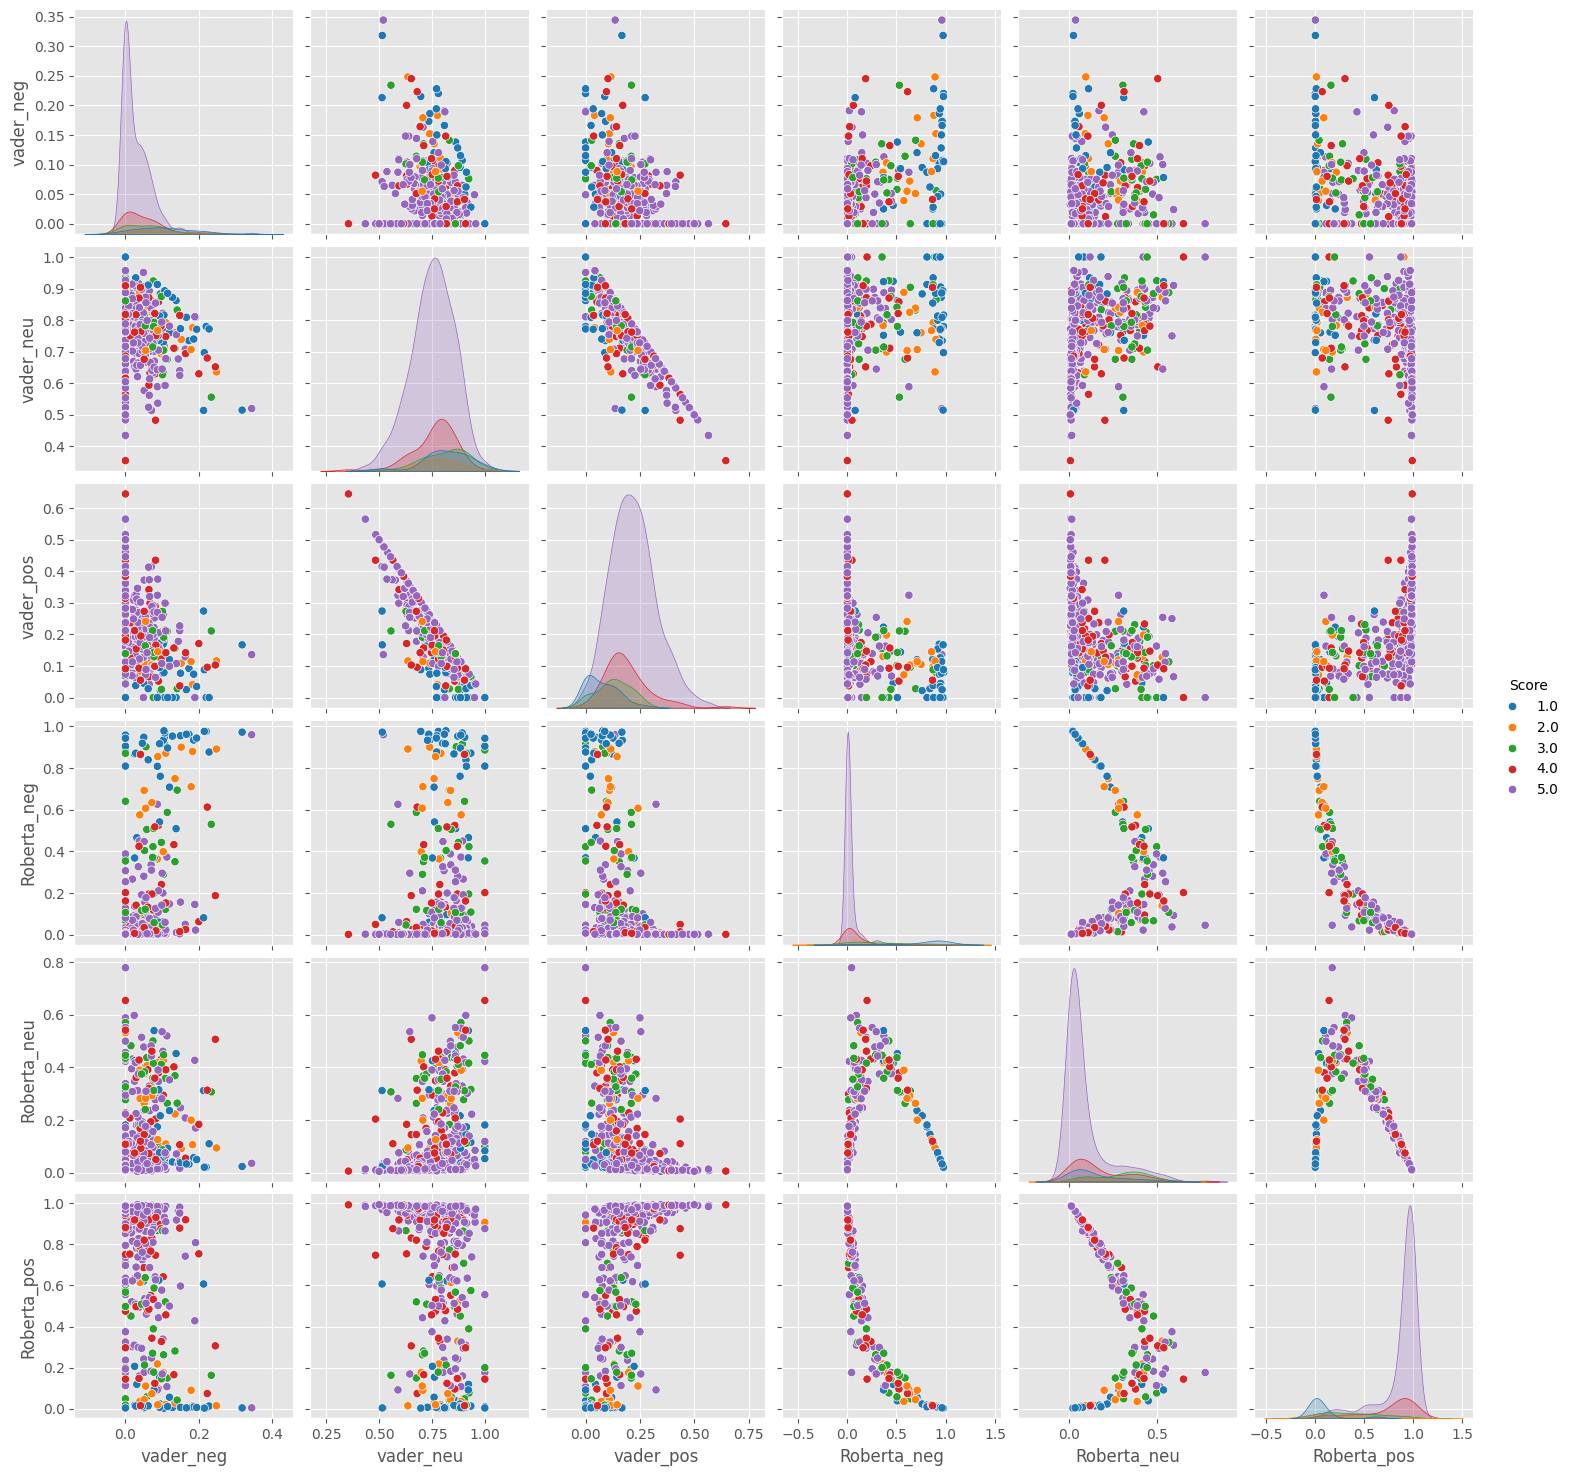

In [ ]:
sns.pairplot(data = results_df,
             vars = ['vader_neg',
                    'vader_neu',
                    'vader_pos',
                    'Roberta_neg',
                    'Roberta_neu',
                    'Roberta_pos'],
#adding color - so we can easily see difference btw each value
hue = 'Score',
palette = 'tab10')
plt.show()

In [ ]:
#Pairplot allows for comparison between each observation and what each feature looks like

In [ ]:
#VADER - pos reviews are moreso to the right for 5 star reviews
#Roberta - way over to the right
#some correlations between VADER and Roberta models
#VADER model is less confident in all of its prediction
#Roberta model clearly separates pos, neu, and neg scores

In [ ]:
#Review examples

In [ ]:
results_df.query('Score == 1') \
  .sort_values('Roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [ ]:
#Highest positivity score where stars = 1 will appear at top

In [ ]:
#Text that the model deems positive but is one star by what the reviewer gave it

In [ ]:
results_df.query('Score == 1') \
  .sort_values('vader_pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [ ]:
#VADER only looks at BoW and score for each word

In [ ]:
#Negative sentiment, 5 star review Roberta:

In [ ]:
results_df.query('Score == 5') \
  .sort_values('Roberta_neg',ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
results_df.query('Score == 5') \
.sort_values('vader_neg', ascending = True)['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
#Hugging face transformers pipeline

In [ ]:
from transformers import pipeline

In [ ]:
#Feed the pipeline tasks it is automatically set up for

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
#^automatically downloads their default model + embeddings for pipeline
#can run sentiment analysis w 2 lines of code

In [ ]:
sentiment_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [ ]:
#reports positive w high confidence

In [ ]:
ssentiment_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]